# EDA – Beispielhafte Datenansicht (Zeitreihen + Wetter + Graph)

Ziel: Ein kurzer, nachvollziehbarer Blick in die gespeicherten CSV-Zeitreihen.
- Auswahl: Node mit größtem Median von `P_MW`
- Anzeige: Kopfzeilen, Basisstatistiken, kurzer Plot
- Wetter: nur kurz mit anzeigen (falls Spalten vorhanden)
- Graph: kurzer Check der Cytoscape-JSON (Elemente, Node/Edge-Anzahlen)


## Imports

In [34]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json


## Pfade zu den Rohdaten

In [35]:
CSV_DIR = Path("src/data/raw/timeseries")   
GRAPH_JSON = Path("src/data/raw/graph/whole_graph.json") 

## Zeitreihen (Last und Wetter)

In [36]:
csv_files = sorted(CSV_DIR.glob("*.csv"))
len(csv_files)

16

Aktuell werden 16 verschiedene Umspannwerksfelder abgebildet

### Beispielhafte exploratorische Analyse eines Umspannwerksfelds

In [49]:
rows = []
for fp in csv_files:
    try:
        df = pd.read_csv(fp)
        if "timestamp" not in df.columns or "P_MW" not in df.columns:
            continue

        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df = df.dropna(subset=["timestamp"])
        df["P_MW"] = pd.to_numeric(df["P_MW"], errors="coerce")

        med = float(df["P_MW"].median(skipna=True))
        rows.append((fp, med, len(df)))
    except Exception:
        continue

med_df = pd.DataFrame(rows, columns=["file", "median_P_MW", "n_rows"]).sort_values("median_P_MW", ascending=False)

best_fp = med_df.iloc[0]["file"]
best_median = med_df.iloc[0]["median_P_MW"]
best_n = int(med_df.iloc[0]["n_rows"])

df = pd.read_csv(best_fp)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"]).sort_values("timestamp")
df["P_MW"] = pd.to_numeric(df["P_MW"], errors="coerce")

df.head(10)


,timestamp,P_MW,temperature_C,wind_speed_mps,solar_radiation_Wm2
0,2024-01-01 00:00:00+00:00,0.000000,6.5,18.8,0.0
1,2024-01-01 00:15:00+00:00,-0.600000,6.5,18.4,0.0
2,2024-01-01 00:30:00+00:00,-0.200000,6.5,18.1,0.0
3,2024-01-01 00:45:00+00:00,0.333333,6.6,17.5,0.0
4,2024-01-01 01:00:00+00:00,0.800000,6.3,18.8,0.0
5,2024-01-01 01:15:00+00:00,0.866667,6.3,18.4,0.0
6,2024-01-01 01:30:00+00:00,0.866667,6.3,18.2,0.0
7,2024-01-01 01:45:00+00:00,0.466667,6.2,17.9,0.0
8,2024-01-01 02:00:00+00:00,0.200000,6.2,17.9,0.0
9,2024-01-01 02:15:00+00:00,0.000000,6.2,17.9,0.0


In [50]:
df.tail(10)


,timestamp,P_MW,temperature_C,wind_speed_mps,solar_radiation_Wm2
71860,2026-01-24 10:30:00+00:00,45.333333,-0.5,22.0,46.0
71861,2026-01-24 10:45:00+00:00,47.333333,-0.5,21.9,49.0
71862,2026-01-24 11:00:00+00:00,38.600000,-0.4,22.0,72.0
71863,2026-01-24 11:15:00+00:00,42.866667,-0.4,21.9,82.0
71864,2026-01-24 11:30:00+00:00,40.466667,-0.4,22.0,85.0
71865,2026-01-24 11:45:00+00:00,42.133333,-0.4,22.0,78.0
71866,2026-01-24 12:00:00+00:00,48.000000,-0.4,22.6,89.0
71867,2026-01-24 12:15:00+00:00,49.533333,-0.4,23.3,95.0
71868,2026-01-24 12:30:00+00:00,45.866667,-0.5,24.4,77.0
71869,2026-01-24 12:45:00+00:00,51.066667,-0.5,25.2,64.0


Die historische Last an diesem Knoten hat sich seit Anfang 2024 scheinbar stark verändert. Von knapp unter 1 MW 2024 zu regelmäßig Leistung über 40 MW in 2026.

#### Verteilung der historischen Last

In [39]:
df[["P_MW"]].describe()


,P_MW
count,71870.000000
mean,20.610127
std,14.893202
min,-27.266667
25%,10.200000
50%,18.600000
75%,28.866667
max,171.666667


Die Verteilung von P_MW ist deutlich rechtsschief: Der Median liegt mit 18,6 MW unter dem Mittelwert, was auf seltene, aber starke Lastspitzen hinweist. Negative Minimalwerte deuten auf Einspeisephasen oder Mess-/Vorzeichenkonventionen hin, während der Großteil der Werte im Bereich von ca. 10–30 MW liegt.

#### Deskriptive Statistik zu den historischen Wetterdaten

In [52]:
weather_cols = ['temperature_C', 'wind_speed_mps', 'solar_radiation_Wm2']

df[weather_cols].describe().T[["mean", "std", "min", "50%", "max"]]

,mean,std,min,50%,max
temperature_C,9.681223,6.533729,-14.4,9.5,31.3
wind_speed_mps,16.329189,8.567299,0.0,15.2,58.6
solar_radiation_Wm2,112.862251,187.514401,0.0,0.0,867.0


Temperatur: Moderate Streuung mit symmetrischer Verteilung um ca. 9–10 °C und klar begrenzten Extremen, typisch für ein mitteleuropäisches Jahresklima.

Wind: Hohe Variabilität mit deutlich ausgeprägten Spitzen; der Median nahe am Mittelwert spricht für häufig mittlere Windgeschwindigkeiten bei gelegentlichen Starkwindereignissen.

Solarstrahlung: Stark rechtsschief verteilt mit einem Median von 0 W/m², was den dominanten Nachtanteil widerspiegelt; relevante Werte treten gebündelt in Tages- und Sommerphasen auf.

#### Visualisierung der historischen Leistung

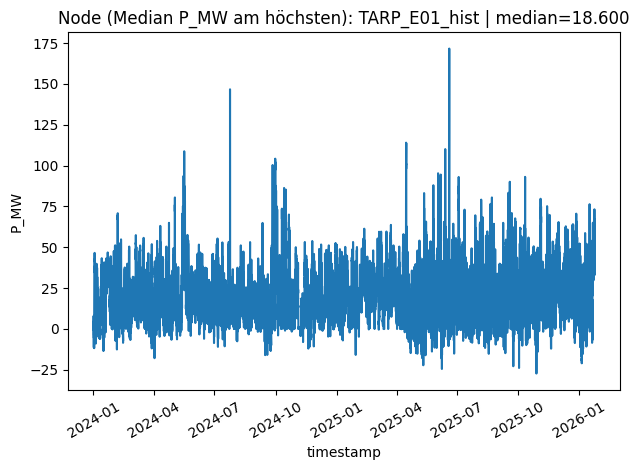

In [42]:
# P_MW Plot
plt.figure()
plt.plot(df["timestamp"], df["P_MW"])
plt.title(f"Node (Median P_MW am höchsten): {best_fp.stem} | median={best_median:.3f}")
plt.xlabel("timestamp")
plt.ylabel("P_MW")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Man sieht eine stark volatile Wirkleistungszeitreihe mit häufigen Peaks, wobei der Median bei ca. 18,6 MW liegt und einzelne Ausreißer deutlich darüber hinausgehen. Insgesamt deutet das auf eine überwiegend moderate Grundlast mit sporadischen Lastspitzen und Phasen erhöhter Aktivität im Zeitverlauf hin.

#### Visualisierung der historischen Wetterdaten

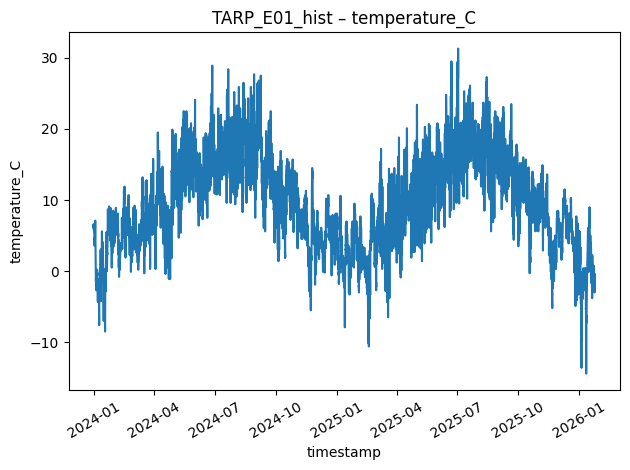

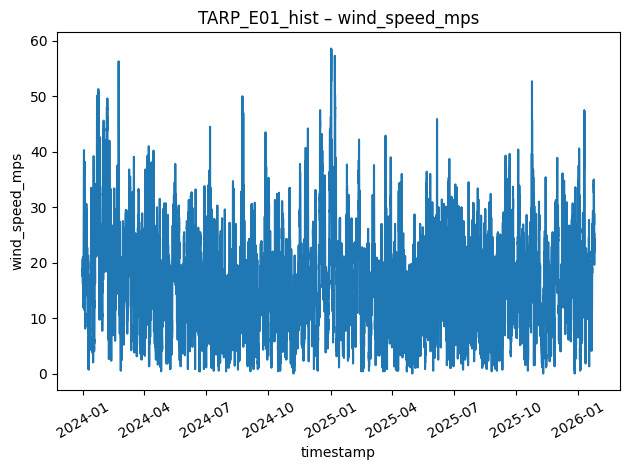

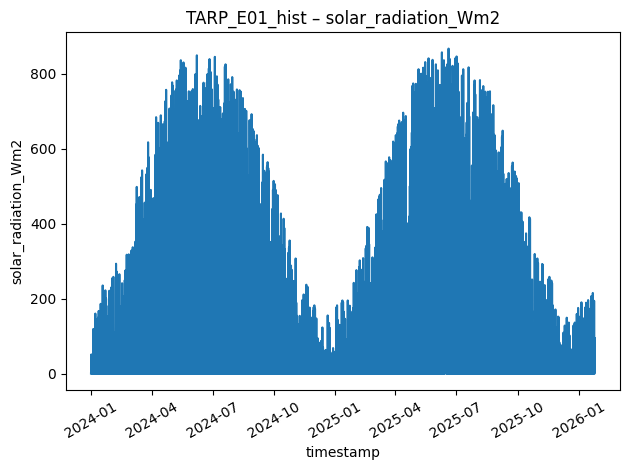

In [ ]:
for c in weather_cols[:3]:
    plt.figure()
    plt.plot(df["timestamp"], pd.to_numeric(df[c], errors="coerce"))
    plt.title(f"{best_fp.stem} – {c}")
    plt.xlabel("timestamp")
    plt.ylabel(c)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


Temperatur: Klar ausgeprägte saisonale Struktur mit Sommermaxima und Winterminima; der Verlauf ist glatt und stark periodisch, kurzfristige Extreme spielen eine untergeordnete Rolle.

Wind: Sehr hohe Kurzfrist-Volatilität ohne klare Saisonalität; starke Peaks und schnelle Wechsel deuten auf ein stark stochastisches Signal hin.

Solarstrahlung: Deutlichste Saisonalität aller Wettervariablen mit klaren Sommer- und Winterphasen sowie ausgeprägtem Tagesgang, was sie strukturell gut erklärbar, aber nur tagsüber relevant macht.

#### Korrelation von Lastwerten mit Wetterdaten

In [ ]:
corrs = {}
for c in weather_cols:
    x = pd.to_numeric(df[c], errors="coerce")
    y = df["P_MW"]
    corrs[c] = x.corr(y)

pd.Series(corrs).sort_values(ascending=False)


wind_speed_mps         0.606691
solar_radiation_Wm2    0.133070
temperature_C          0.033218
dtype: float64

Die Korrelationen zeigen, dass Wind der mit Abstand wichtigste exogene Treiber für 
P_MW ist, während Solarstrahlung nur einen schwachen und Temperatur praktisch keinen linearen Zusammenhang aufweist.
Das stützt die Modellwahl: Wetterdaten sind sinnvoll, aber der prognostische Mehrwert kommt hier fast ausschließlich über Wind, die anderen Variablen wirken eher unterstützend bzw. indirekt.

In [ ]:
with open(GRAPH_JSON, "r", encoding="utf-8") as f:
    elems = json.load(f)

len(elems), type(elems)

nodes = []
edges = []
for el in elems:
    d = (el or {}).get("data", {}) or {}
    if "source" in d and "target" in d:
        edges.append(el)
    else:
        nodes.append(el)

node_types = pd.Series([(n.get("data", {}) or {}).get("type") for n in nodes]).value_counts(dropna=False)
len(nodes), len(edges), node_types


(29,
 29,
 uw_field    14
 busbar       7
 junction     6
 battery      2
 Name: count, dtype: int64)

Der Graph umfasst insgesamt 29 Knoten, wobei UW-Felder dominieren (14), gefolgt von Sammelschienen (7) und Leitungsknoten (6); Batterien (2) sind nur randständig vertreten.

## Beispielplot Vergangenheit + Prognose

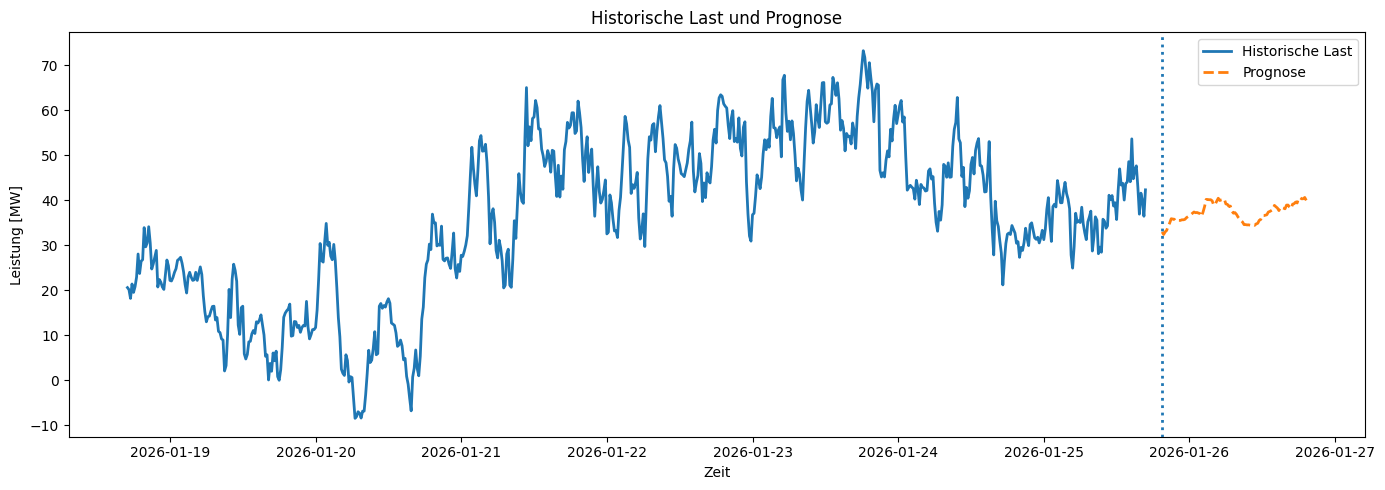

In [8]:

hist = pd.read_csv(
    "src/data/raw/timeseries/TARP_E01_hist.csv",
    parse_dates=["timestamp"]
)

fc = pd.read_csv(
    "src/data/pred/TARP_E01_pred.csv",
    parse_dates=["timestamp"]
)

# letzte 7 Tage bei 15-min-Auflösung
hist_plot = hist.tail(7 * 96)   
fc_plot = fc.head(96)      

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
plt.figure(figsize=(14, 5))

plt.plot(
    hist_plot["timestamp"],
    hist_plot["P_MW"],
    label="Historische Last",
    linewidth=2
)

plt.plot(
    fc_plot["timestamp"],
    fc_plot["P_MW_pred"],
    label="Prognose",
    linestyle="--",
    linewidth=2
)

# Trennlinie Historie / Prognose
plt.axvline(
    fc_plot["timestamp"].iloc[0],
    linestyle=":",
    linewidth=2
)

plt.xlabel("Zeit")
plt.ylabel("Leistung [MW]")
plt.title("Historische Last und Prognose")
plt.legend()
plt.tight_layout()
plt.show()


Die Abbildung zeigt den Übergang von historischer Last zu einer kurzfristigen Prognose. Die Prognose schließt unmittelbar an den zuletzt verfügbaren Messzeitpunkt an und setzt diesen zeitlich fort. Die kleine Lücke in der historischen Zeitreihe kurz vor dem Prognosebeginn ist auf verzögert eintreffende Messwerte im operativen Betrieb zurückzuführen und stellt keinen Modellfehler dar, da die Prognose ausschließlich auf den bis zu diesem Zeitpunkt vorliegenden Daten basiert.